#### Astronomy 406 "Computational Astrophysics" (Fall 2016)

### Week 9: Markov Chain Monte Carlo and Monte Carlo integration

<b>Reading:</b> notes below, as well as [$\S$15.8](https://umich.instructure.com/files/655099/download), [$\S$7.7-7.9](https://umich.instructure.com/files/715726/download) of [Numerical Recipes](http://numerical.recipes/), and $\S$5.8 of [Machine Learning](http://www.astroml.org/).

In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 90
import numpy as np
import matplotlib.pyplot as plt
from astroML.plotting import hist

When the model we want to fit to a dataset has many parameters, direct maximization of the likelihood may be impractical.  In this case the Markov Chain Monte Carlo (MCMC) methods provide a powerful way of estimating the parameters of a model and their degree of uncertainty. MCMC is based on the ideas of Bayesian statistical inference.

Thomas Bayes wrote a manuscript (published posthumously in 1763) on how to combine an initial belief with new data to arrive at an improved belief.  This idea was rediscovered and popularized by Pierre Simon Laplace.  However, practical application of Bayesian methods became common only in the second half of the 20th century, with the rise of the computer.

Bayes's rule relates conditional probabilities of two random variables $p(y\,|\,x) \, p(x) = p(x\,|\,y) \, p(y)$.  

$p(y\,|\,x)$ reads <i>probability of $y$ given $x$</i>.  $p(y)$ is <i>marginal probability function</i>: $p(y) = \int p(y\,|\,x) \, p(x) dx$, which is the probability of $y$ marginalized over all (for all cases of) $x$.

When applied to a set of data points $D$ described by model $M$ (with parameters $\mathbf{x}$), this rule gives Bayes's theorem:

$$p(M\,|\,D) = \frac{p(D\,|\,M) \, p(M)}{p(D)}$$

where $p(D\,|\,M)$ is the familiar likelihood function (which is really the probability of data set drawn from a distribution given by the model).  The new part here is $p(M)$, the model prior distribution function.  This theorem combines the initial belief $p(M)$ and the probability that it generated the observed data set $p(D\,|\,M)$, to produce the improved belief $p(M\,|\,D)$, which is called the <i>posterior probability</i>.

The prior distribution containts the priors on model parameters $\mathbf{x}$ and other information $I$, for example the functional form: $p(M) = p(\mathbf{x}\,|\,I) p(I)$.  

Priors are typically taken to be <i>flat</i>: $p(x) = const$ for $x_{min} < x < x_{max}\,$ and $p(x) = 0$ otherwise; 

or <i>scale-invariant</i> (flat in $log x$): $p(x) \propto 1/x$.<br>
This means we can rescale our measurement units by a constant factor $a$ without affecting the probability: $p(x) dx = p(ax) d(ax)$. (Priors can also be Gaussian.)

The posterior can rewritten as $p(M\,|\,D) \equiv \pi(\mathbf{x}\,|\,D,I)$.  We would like to sample $\pi(\mathbf{x})$ to obtain the distribution of model parameters, but we can't do it directly because $\pi(\mathbf{x})$ is not properly normalized.  This is where MCMC comes to rescue. (Because $\pi(\mathbf{x})$ is not properly normalized, we can't use some of the methods we learned previously about drawing from a distribution - requires a normalized function).

<i>Monte Carlo</i> is in MCMC because it involves random samples, <i>Markov Chain</i> is because sampling algorithm depends only on the previous sample (the so-called Markov process): the probability of step from $\mathbf{x}_i$ to $\mathbf{x}_{i+1}$ depends only on $\mathbf{x}_i$ and not on all previous chain ($\mathbf{x}_{i-1}, \mathbf{x}_{i-2}, ...$).

The key concept of the MCMC method is statistical equilibrium. The method was developed by physicists to model thermodynamic properties of particle systems, in which approach to equlibrium depends on interaction between particles. Likewise, in the MCMC method the equilibrium distribution of points $\mathbf{x}_i$ that sample the target distribution is achieved by choosing appropriate transition probabilities. To reach equilibrium the transition probability must be symmetric: $p(\mathbf{x}_{i+1}\,|\,\mathbf{x}_i) \, \pi(\mathbf{x}_i) = p(\mathbf{x}_i\,|\,\mathbf{x}_{i+1}) \, \pi(\mathbf{x}_{i+1})$. 

This is called the detailed balance condition.  It guarantees that the chain will sample $\mathbf{x}$ in proportion to $\pi(\mathbf{x})$ ("ergodically").

The simplest MCMC algorithm is the Metropolis method. The Metropolis step takes a position $\mathbf{x}_i$ in parameter space to the position $\mathbf{x}_{i+1}$ using the following steps:

1. propose a new position $\mathbf{x}_c$ drawn from a multivariate Gaussian centered on the current position $\mathbf{x}_i$ (or any other function that can reach anywhere in the region of interest)
2. compute the probability of the new position $\pi(\mathbf{x}_c\,|\,D)$
3. draw a random number $r$ between 0 and 1 and if

$$ r < \frac{\pi(\mathbf{x}_c\,|\,D)}{\pi(\mathbf{x}_i\,|\,D)} $$

return $\mathbf{x}_c$ as $\mathbf{x}_{i+1}$, or otherwise repeat $\mathbf{x}_i$ as $\mathbf{x}_{i+1}$ (this repetition is important - we must create a new link in the chain).

The algorithm depends only on the ratio of posteriors, and thus works even when $\pi(\mathbf{x})$ is not normalized.

Let's take again our familiar example of linear regression.

In [2]:
Lgal, dLgal, Mgc, dMgc = np.loadtxt("gc_galaxy.dat", unpack=True)

ind = (Lgal > 9) 
x = Lgal[ind]; dx = dLgal[ind]; y = Mgc[ind]; dy = dMgc[ind];

Logarithms of the Likelihood, Prior distribution, and Posterior distribution:

In [3]:
def lnLikelihood(p):
    b = p[0]
    sig = p[1]
    a = p[2]
    w = 1./(sig**2 + dy**2 + (b*dx)**2)
    twologL = np.sum(np.log(w) - w*(y-a-b*x)**2)
    return twologL

def lnPrior(p):
    if not (0 < p[0] < 2):
        return -np.inf
    if not (-2 < p[1] < 2):
        return -np.inf
    if not (-100 < p[2] < 100):
        return -np.inf        
    return 0.0

def lnPosterior(p):
    return lnPrior(p) + lnLikelihood(p)

One step of the Metropolis algorithm:

In [4]:
def Metropolis_step(lnpost_function, p, lnpost_p, pcov, naccept):
    q = np.random.multivariate_normal(p, pcov) #Key line - how we go from one step to the next
    lnpost_q = lnpost_function(q)
    r = np.random.rand()
    if(r <= np.exp(lnpost_q-lnpost_p)):
        #accept new step
        naccept += 1
        return q, lnpost_q, naccept
    else:
        #reject new step and repeat old step
        return p, lnpost_p, naccept

Let's run a simple Markov chain with a fixed number of steps:

In [5]:
nsteps = 100000

# Starting point
p = np.array([1., 1., 1.])
# Proposal covariance
step = np.diag([0.0001, 0.0001, 0.0001])

lnpost_p = lnPosterior(p)
chain = np.empty((nsteps, len(p)))

# Number of accepted steps
na = 0
np.random.seed(0)

for n in range(nsteps):
    p, lnpost_p, na = Metropolis_step(lnPosterior, p, lnpost_p, step, na)
    chain[n] = p
    
# Compute the acceptance fraction.
acc = float(np.any(np.diff(chain, axis=0), axis=1).sum())/(len(chain)-1)
print "mean acceptance fraction = {0:.4f}  (na = {1:.4f})".format(acc, 1.*na/nsteps)

print "b = {0:.3f} ± {1:.3f}  s = {2:.3f} ± {3:.3f}  a = {4:.3f} ± {5:.3f}"\
  .format(np.mean(chain[:,0]), np.std(chain[:,0]), \
   np.mean(np.abs(chain[:,1])), np.std(np.abs(chain[:,1])), \
   np.mean(chain[:,2]), np.std(chain[:,2]))

mean acceptance fraction = 0.1882  (na = 0.1882)
b = 1.356 ± 0.159  s = 0.385 ± 0.052  a = -5.892 ± 1.635


Here is how our parameters have changed along the chain:

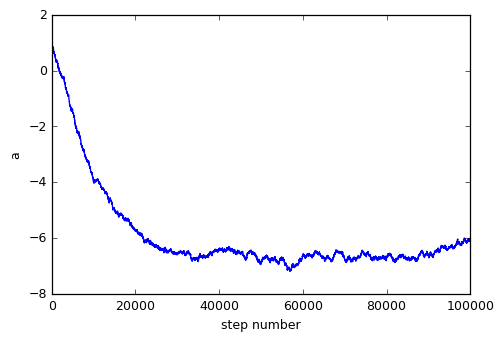

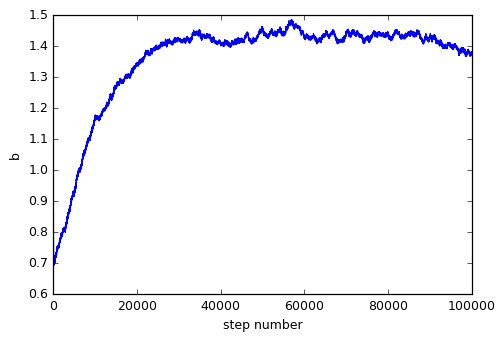

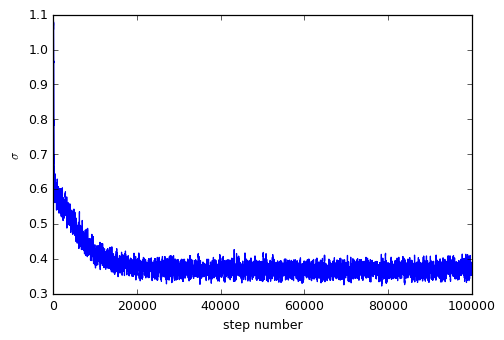

In [6]:
plt.plot(chain[:,2], 'b')
plt.xlabel('step number')
plt.ylabel('a')
plt.show()

plt.plot(chain[:,0], 'b')
plt.xlabel('step number')
plt.ylabel('b')
plt.show()

plt.plot(chain[:,1], 'b')
plt.xlabel('step number')
plt.ylabel('$\sigma$')
plt.show()

The first necessary correction is to remove ("burn") the memory of the initial state.

We can decide how long to run the chain based on the convergence of the parameters.

In [7]:
nsteps = 400000
nburn = 20000
ncheck = 10000

# Starting point
p = np.array([1., 1., 1.])
# Proposal covariance
step = np.diag([0.0001, 0.0001, 0.0001])

pmean = np.zeros(len(p))
pstd = np.zeros(len(p))
nconv = np.zeros(len(p), dtype=int)
converged = (pmean > 1)
not_converged = True
nnext = nburn + ncheck

lnpost_p = lnPosterior(p)
chain = np.empty((nsteps, len(p)))
n, na = 0, 0
np.random.seed(0)

while not_converged and n < nsteps:
    p, lnpost_p, na = Metropolis_step(lnPosterior, p, lnpost_p, step, na)
    chain[n] = p
    n += 1
    
    if n >= nnext:
        pmean_last = np.copy(pmean)
        pstd_last = np.copy(pstd)
        pmean = np.mean(chain[nburn:n], axis=0)
        pstd = np.std(chain[nburn:n], axis=0, ddof=1)

        for i in range(len(p)):
            if(not converged[i] and abs(pmean[i]-pmean_last[i]) < 0.001):
                converged[i] = True
                nconv[i] = n
              
        if(converged[0] and converged[1] and converged[2]):
            not_converged = False

        print 'n = %4d: b = %.3f +- %.3f  s = %.3f +- %.3f  a = %.3f +- %.3f  acc = %.3f' \
               %(n, pmean[0], pstd[0], pmean[1], pstd[1], pmean[2], pstd[2], 1.*na/nsteps)
        nnext += ncheck       

print 'chain converged at [b]=%d [s]=%d [a]=%d' % (nconv[0], nconv[1], nconv[2])

n = 30000: b = 1.390 +- 0.024  s = 0.372 +- 0.015  a = -6.249 +- 0.244  acc = 0.015
n = 40000: b = 1.407 +- 0.025  s = 0.371 +- 0.014  a = -6.424 +- 0.256  acc = 0.020
n = 50000: b = 1.411 +- 0.022  s = 0.370 +- 0.014  a = -6.462 +- 0.230  acc = 0.024
n = 60000: b = 1.421 +- 0.026  s = 0.370 +- 0.014  a = -6.561 +- 0.271  acc = 0.029
n = 70000: b = 1.422 +- 0.024  s = 0.369 +- 0.014  a = -6.573 +- 0.247  acc = 0.033
n = 80000: b = 1.424 +- 0.023  s = 0.369 +- 0.014  a = -6.594 +- 0.233  acc = 0.038
n = 90000: b = 1.425 +- 0.021  s = 0.369 +- 0.014  a = -6.606 +- 0.221  acc = 0.042
n = 100000: b = 1.422 +- 0.023  s = 0.369 +- 0.014  a = -6.571 +- 0.234  acc = 0.047
n = 110000: b = 1.418 +- 0.024  s = 0.369 +- 0.014  a = -6.536 +- 0.246  acc = 0.052
n = 120000: b = 1.419 +- 0.023  s = 0.369 +- 0.014  a = -6.543 +- 0.237  acc = 0.057
n = 130000: b = 1.424 +- 0.028  s = 0.369 +- 0.014  a = -6.596 +- 0.285  acc = 0.061
n = 140000: b = 1.424 +- 0.027  s = 0.369 +- 0.014  a = -6.593 +- 0.276 

Let's plot the parameter distributions. There are MANY links in the chain, and so a simple histogram with Knuth's rule would look too fragmented.  It is better to visualize the distributions with a Kernel Density Estimator.

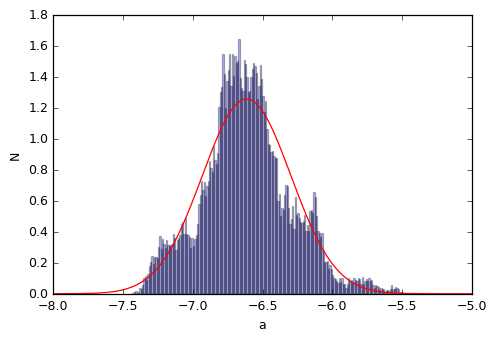

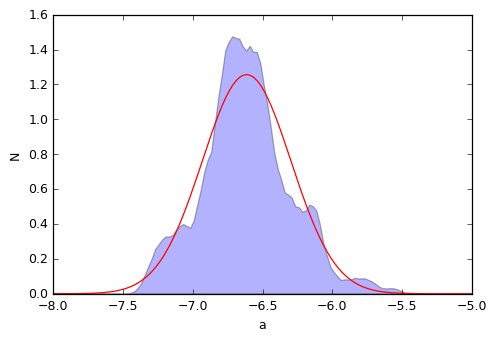

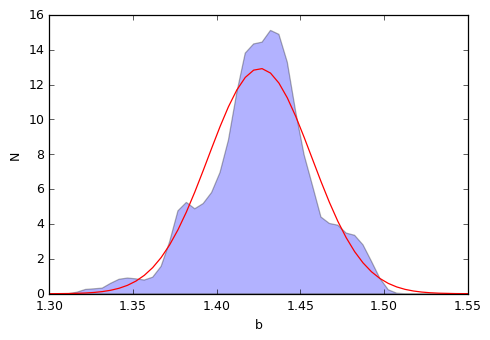

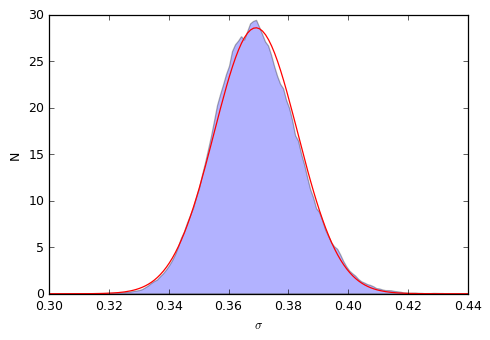

In [20]:
def kde_tophat( data, x, h ):
    y = (abs(x - data[:,None]) <= h).astype(float)
    return y.sum(0)/(2*h*len(data))

def pdf_gauss( x, mu, s ):
    return np.exp(-((x-mu)/s)**2/2)/(np.sqrt(2*np.pi)*s)

xx = np.linspace(-9, -4, 200)
hist(chain[nburn:n:1,2], bins='knuth', alpha=0.3, normed=True)
plt.plot(xx, pdf_gauss(xx, pmean[2], pstd[2]), '-r')
plt.xlim(-8, -5)
plt.xlabel('a')
plt.ylabel('N')
plt.show()

plt.fill(xx, kde_tophat(np.array(chain[nburn:n,2]), xx, 0.05), alpha=0.3)
plt.plot(xx, pdf_gauss(xx, pmean[2], pstd[2]), '-r')
plt.xlim(-8, -5)
plt.xlabel('a')
plt.ylabel('N')
plt.show()

xx = np.linspace(1, 2, 200)
plt.fill(xx, kde_tophat(np.array(chain[nburn:n,0]), xx, 0.005), alpha=0.3)
plt.plot(xx, pdf_gauss(xx, pmean[0], pstd[0]), '-r')
plt.xlim(1.3, 1.55)
plt.xlabel('b')
plt.ylabel('N')
plt.show()

xx = np.linspace(0.3, 0.5, 200)
plt.fill(xx, kde_tophat(np.array(chain[nburn:n,1]), xx, 0.002), alpha=0.3)
plt.plot(xx, pdf_gauss(xx, pmean[1], pstd[1]), '-r')
plt.xlim(0.3, 0.44)
plt.xlabel('$\sigma$')
plt.ylabel('N')
plt.show()

A pretty way to plot the parameter distributions is provided by the <b>corner</b> package. You can install in your python distribution by typing <tt>pip install corner</tt> in python command prompt.

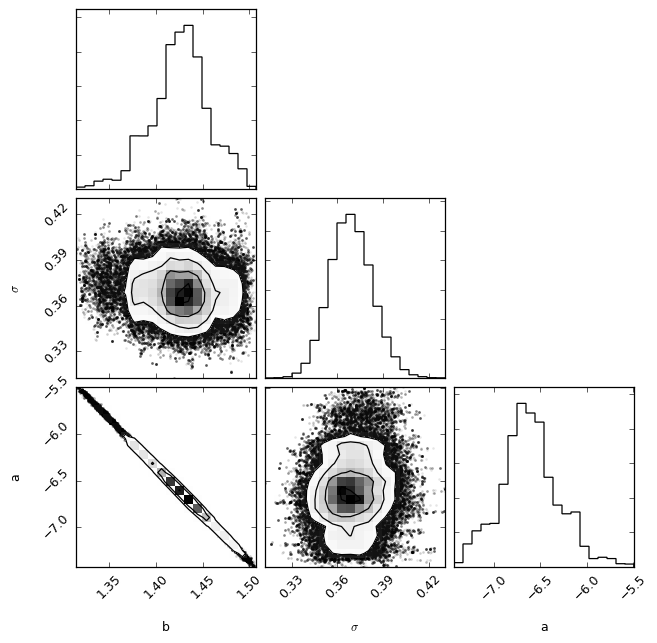

In [8]:
import corner
corner.corner(chain[nburn:n], labels=['b', '$\sigma$', 'a'], bin=30)
plt.show()

#These plots show correlation - a and b are highly correlated,
#as we expect, while a and sigma and b and sigma are not.

An example of use of MCMC for a Gaussian Mixture is given in <a href="http://www.astroml.org/book_figures/chapter5/fig_model_comparison_mcmc.html">Figure 5.24</a> in ML.

An efficient implementation of MCMC ensemble sampler is the [<b>emcee</b>](http://dan.iel.fm/emcee/current/) package.  Here is how one could use for our example above.

In [18]:
import emcee #Does the same as above, but is much more efficient

ndim = 3
nwalkers = 100
nsteps = 300000
nburn = 20000
np.random.seed(0)

# Choose an initial set of positions for the walkers
p0 = [np.random.rand(ndim) for i in xrange(nwalkers)]

# Initialize the sampler with the chosen specs
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnPosterior)

# Run burn-in steps
pos, prob, state = sampler.run_mcmc(p0, nburn/nwalkers) #last entry is number of burn steps per walker

# Reset the chain to remove the burn-in samples
sampler.reset()

# Starting from the final position in the burn-in chain, sample nsteps
sampler.run_mcmc(pos, nsteps/nwalkers, rstate0=state)

# Print out the mean acceptance fraction among all walkers
print "Mean acceptance fraction = %.3f" % np.mean(sampler.acceptance_fraction)

# Estimate the integrated autocorrelation time for the time series in each parameter.
#print "Autocorrelation length =", sampler.get_autocorr_time()

print "b = {0:.3f} +- {1:.3f}  s = {2:.3f} +- {3:.3f}  a = {4:.3f} +- {5:.3f}"\
  .format(np.mean(sampler.flatchain[:,0]), np.std(sampler.flatchain[:,0]), \
   np.mean(np.abs(sampler.flatchain[:,1])), np.std(np.abs(sampler.flatchain[:,1])), \
   np.mean(sampler.flatchain[:,2]), np.std(sampler.flatchain[:,2]))
#sampler.flatchain is a 2D array of all the 'walkers' for each parameter - all the walkers
#collapsed into one

 Mean acceptance fraction = 0.537
b = 1.430 +- 0.058  s = 0.370 +- 0.033  a = -6.663 +- 0.542


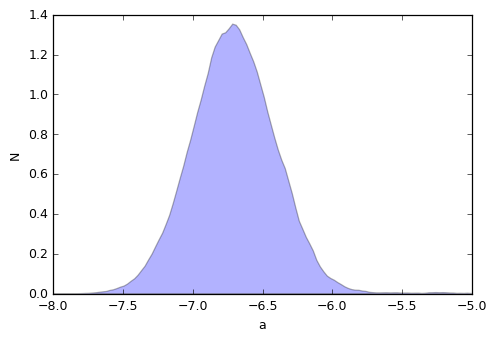

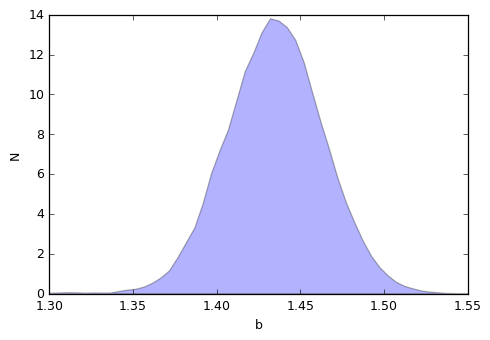

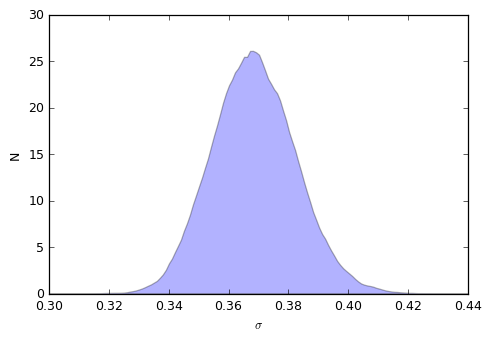

In [21]:
xx = np.linspace(-9, -4, 200)
plt.fill(xx, kde_tophat(np.array(sampler.flatchain[:,2]), xx, 0.05), alpha=0.3)
plt.xlim(-8, -5)
plt.xlabel('a')
plt.ylabel('N')
plt.show()

xx = np.linspace(1, 2, 200)
plt.fill(xx, kde_tophat(np.array(sampler.flatchain[:,0]), xx, 0.005), alpha=0.3)
plt.xlim(1.3, 1.55)
plt.xlabel('b')
plt.ylabel('N')
plt.show()

xx = np.linspace(0.3, 0.5, 200)
plt.fill(xx, kde_tophat(np.array(sampler.flatchain[:,1]), xx, 0.002), alpha=0.3)

plt.xlim(0.3, 0.44)
plt.xlabel('$\sigma$')
plt.ylabel('N')
plt.show()

Let's look at a part of the chain (for the first parameter).  Note that it has correlated values over a certain interval of steps.

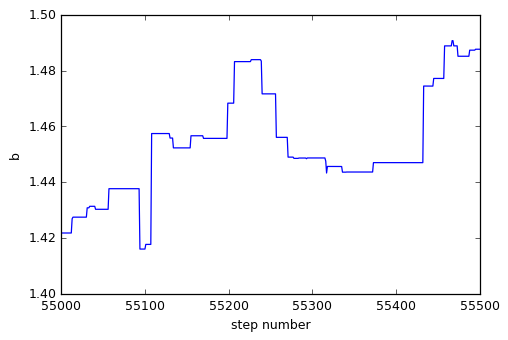

In [23]:
plt.xlabel('step number')
plt.ylabel('b')
plt.xlim(55000, 55500)
plt.ylim(1.4, 1.5)
plt.plot(sampler.flatchain[:,0], 'b')
plt.show()
#There are swings and variations in the parameter as we walk. In theory, each step should be a 
#random evaluation; in practice, there is a sort of momentum - if we go up for a couple, we're
#going to keep going up for a stretch.

The autocorrelation length calculated by <b>emcee</b> is about 90.  Do you see features of this size on the plot?

Yes - We have blocks of one value that persist for about 90 blocks. There is then some correlation between results. A way to correct that is to 'thin the sample' - pick only one point out of each block of n steps, where n is the correlation length.

### Convergence indicators

Two general types of convergence criteria have been proposed in the literature: testing stationarity of the chain parameter distribution ([Gelman & Rubin 1992](https://projecteuclid.org/euclid.ss/1177011136), [Brooks & Gelman 1998](https://stat.duke.edu/~scs/Courses/Stat376/Papers/ConvergeDiagnostics/BrooksGelman.pdf)), or measuring the auto-correlation length of the chain samples  compared to the total length of the chain ([Dunkley 2005](http://adsabs.harvard.edu/abs/2005MNRAS.356..925D), [Goodman & Weare 2010](http://msp.org/camcos/2010/5-1/p04.xhtml)).

<b>The Gelman-Rubin indicator</b>

The idea behind this indicator is that if we have a number of individually advanced chains ("walkers"), we can compare the variance we get within each chain to the variance we get among different chains. Perfect convergence would correspond to the "within chain" and "between chain" values of the variance matching each other. Thus, the Gelman-Rubin indicator is defined as the ratio of the two variances:
$$
R=\frac{V}{W}=\frac{N_w+1}{N_w}\frac{\sigma^2_+}{W}-\frac{N-1}{N_w N},
$$
where  $N_w$ is the number of walkers (independent chains) and $N$ is the total length of each of the individual chains,  
$$
\sigma^2_+=\frac{N-1}{N}W + \frac{B}{N};
$$
if we denote the random variable vector $\vec{x}$ and denote $\vec{x}_{jt}$ the $t$th of the $N$ steps of the chain $j$ "between-walker" variance is
$$
\frac{B}{N}=\frac{1}{N_w-1}\sum\limits_{j=1}^{N_w}(\bar{\vec{x}}_{j.}-\bar{\vec{x}}_{..})^2
$$
and "within chain" variance $W$ is 
$$
W=\frac{1}{N_w(N-1)}\sum\limits_{j=1}^{N_w}\sum\limits_{t=1}^{N}(\vec{x}_{jt}-\vec{x}_{j.})^2
$$

Examples below show the convergence indicator $R_{\rm GR}\equiv R-1.0$ calculated after every $1000^{\rm th}$ step as a function of step in the chains run with the [Goodman & Weare (2010)](http://msp.org/camcos/2010/5-1/p04.xhtml) ensemble sampling algorithm for the 2D Gaussian and Rosenbrock pdf using a given number $N_w={\tt nwalkers}$ independent chains. The chains for the Gaussian pdf converge relatively fast. However, the difficulty of the Rosenbrock "banana" pdf will be apparent in the slow convergence of $R_{\rm GR}$ to zero.

<b>Indicators based on the auto-correlation time</b>

The second commonly used measure of convergence is the <i>auto-correlation time.</i> By design, MCMC samples are correlated over a certain number of steps, often quite strongly. Such correlations can bias estimates of the variance of the parameters and thus one needs to know the frequency of the truly independent samples. Moreover, it is the number of independent samples that actually matters for the accuracy of the quantities estimated from the MCMC chains, not the total number of generated samples.  The auto-correlation time defined below is a natural quantity to measure the spacing between samples that can be considered independent. It can be used to come up with criteria to estimate the <i>burn-in</i> length of improbable samples at the beginning of the chain. It can further be used to figure out how many independent samples the chains have and what is the corresponding accuracy of the estimated parameters that can then be used to come up with criteria for stopping the chains, as described below.  

For some real valued function of the parameter vector $f=f(\mathbf{x})$. Now consider the stationary Markov chain (i.e.
start the system in the stationary distribution $\pi(\mathbf{x})$, or equivalently, equilibrate it for a
very long time prior to observing the system). Then $\{f\}\equiv \left\{f(\mathbf{x}_t)\right\}$ is a stationary
stochastic process with mean

$$
\mu_f\equiv \langle f\rangle=\sum\limits_{j}\pi(\mathbf{x}_j)f(\mathbf{x}_j)
$$

Note that function $f$ here is whatever quantity or function that you are interested in to get from the MCMC chain. For example, if you are interested in the parameters themselves: $f(\mathbf{x}_j)=\mathbf{x}_j$ - i.e, in the 2D pdfs considered below, $f_1=x_1$ and $f_2=x_2$ (you estimate auto-correlation time for the two parameters separately). If for some reason you are interested instead in $x_1^2+x^2_2$, you should use $f=x_1^2+x^2_2$ in the computation of the correlation function. 

The unnormalized auto-correlation function of the chain is 
$$C_{ff}(t)=\langle f_sf_{s+t}\rangle-\mu_f^2,$$
while the normalized function is
$$\rho_{ff}(t)\equiv C_{ff}(t)/C_{ff}(0).$$ The auto-correlation time can be measured directly from $\rho_{ff}$. However, typically $\rho_{ff}$ can be approximated as an exponential $\rho_{ff}(t)\approx \exp^{-t/\tau}$ so that the <i>exponential auto-correlation time can be defined</i> for large $t\rightarrow\infty$:
$$\tau_{exp,f}=\max\left(\frac{t}{-\log\vert\rho_{ff}\vert}\right)$$
The overall autocorrelation time is then
$$
\tau_{exp}=\max_f\tau_{exp,f},
$$
i.e., the auto-correlation time is equilibration time of the slowest mode in the system.

We will be using the <tt>acor</tt> python wrapper for the C++ routines of Goodman written by Dan Foreman-Mackey. You can get it by installing in your python distro using <tt>pip install acor</tt>, or get it [here](https://pypi.python.org/pypi/acor/1.1.1) directly.

### Convergence criteria

Once we have an estimate of $R_{\rm GR}$ and $\tau_{\rm exp}\,$ we need criteria for how to decide on convergence. 

$R_{\rm GR}$ should be steadily approaching unity near equilibrium, for example $R_{\rm GR} < 1.01$.

Given that we will estimate quantities of interest from the Monte Carlo samples of the posterior, the fractional accuracy of the estimate will be $\approx 1/\sqrt{N}$, where $N$ is the number of <i>independent</i> samples. That is $N$ is not the total number of samples we have generated in the MCMC chains, $N_s$, but only a fraction of them that can be considered independent. Auto-correlation time $\tau_{\rm exp}$ gives us the number of iterations spacing independent samples and thus the fractional error of estimating a parameter from MCMC will be
$$\epsilon\approx\left(\frac{\tau_{\rm exp}}{N_s-N_{\rm b}}\right)^{1/2},$$
where $N_s$ is the total number of samples in the chain after $N_{\rm b}$ burn-in samples are removed. Thus, to reach $1\%$ accuracy in a given parameter one needs a chain of length $N_s\approx 10^4\tau_{\rm exp}+N_{\rm b}$.

#### Exercise with a 2D Gaussian function

Let's do a simple test with a 2D Gaussian with non-zero correlation - a fairly typical posterior for two well-constrained parameters. The routine below implements the Gelman-Rubin indicator calculation.

In [24]:
def GR_indicator(mwx, swx, mwy, swy, nchain):
    mwxc = mwx/(nchain-1.);  mwyc = mwy/(nchain-1.) 
    swxc = swx/(nchain-1.)-np.power(mwxc,2)
    swyc = swy/(nchain-1.)-np.power(mwyc,2)
    # within chain variance
    Wgrx = np.sum(swxc)/nwalkers; Wgry = np.sum(swyc)/nwalkers
    # mean of the means over Nwalkers
    mx = np.sum(mwxc)/nwalkers; my = np.sum(mwyc)/nwalkers
    # between chain variance
    Bgrx = nchain*np.sum(np.power(mwxc-mx,2))/(nwalkers-1.)
    Bgry = nchain*np.sum(np.power(mwyc-my,2))/(nwalkers-1.)
        
    # Gelman-Rubin R factor
    Rgrx = (1 - 1/nchain + Bgrx/Wgrx/nchain)*(nwalkers+1)/nwalkers - (nchain-1)/(nchain*nwalkers)
    Rgry = (1 - 1/nchain + Bgry/Wgry/nchain)*(nwalkers+1)/nwalkers - (nchain-1)/(nchain*nwalkers)

    return Rgrx, Rgry

Then we implement the modelpdf and a routine to plot the resulting sampling pdf and 68% and 99% confidence contours to make sure that sampling is done correctly. 

In [35]:
from matplotlib.colors import LogNorm
from scipy import optimize

def conf_interval(x, pdf, conf_level):
    return np.sum(pdf[pdf > x])-conf_level


def plot_samples(xh, yh):
    x = np.arange(np.min(xh)-1, np.max(xh)+1, 0.05)
    y = np.arange(np.min(yh)-1, np.max(yh)+1, 0.05)

    X, Y = np.meshgrid(x,y)
    xs = np.array(zip(X,Y))
    Z = modelpdf(xs)

    plt.title('MCMC samples vs target distribution')    
    plt.ylabel('y')
    plt.xlabel('x')
    
    plt.hist2d(xh, yh, bins=100, norm=LogNorm(), normed=1)
    plt.colorbar()

    dlnL2= np.array([2.30, 9.21]) # contours enclosing 68.27 and 99% of the probability density
    xc = np.zeros([1,2])
    Lmax = modelpdf(xc)
    lvls = np.flipud(Lmax/np.exp(0.5*dlnL2))
    cs = plt.contour(X,Y,Z, linewidths=(1,2), colors='black', norm = LogNorm(), levels = lvls, legend='target pdf' )

    xmin = -4; xmax = 4; nbins = 80; dx = (xmax-xmin)/nbins; dx2 = dx*dx
    H, xbins, ybins = np.histogram2d(xh, yh,  bins=(np.linspace(xmin, xmax, nbins), np.linspace(xmin, xmax, nbins)))

    H = np.rot90(H); H = np.flipud(H); Hmask = np.ma.masked_where(H==0,H)
    H = H/np.sum(H)    

    clevs = [0.99, 0.6827]

    lvls =[]
    for cld in clevs:  
        sig = optimize.brentq( conf_interval, 0., 1., args=(H,cld) )  
        lvls.append(sig)

    plt.contour(H, linewidths=(3.,2.), colors='magenta', levels = lvls, norm = LogNorm(), extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]])

    labels = ['68.27%', '99%']
    for i in range(len(labels)):
        cs.collections[i].set_label(labels[i])
        
    plt.show()

In [32]:
# 2D Gaussian function with correlation between variables
def modelpdf(x):
    sig1 = 1.; sig2 = 1.; r = 0.95;
    r2 = r*r
    x1 = x[:,0]
    x2 = x[:,1]
    return np.exp(-0.5*((x1/sig1)**2+(x2/sig2)**2-2*r*x1*x2/(sig1*sig2))/(1-r2))/(2*np.pi*sig1*sig2)/np.sqrt(1-r2)

def modelpdf2(x1,x2):
    sig1 = 1.; sig2 = 1.; r = 0.95;
    r2 = r*r
    return np.exp(-0.5*((x1/sig1)**2+(x2/sig2)**2-2*r*x1*x2/(sig1*sig2))/(1-r2))/(2*np.pi*sig1*sig2)/np.sqrt(1-r2)

Finally, we have the code that implements the Goodman & Weare (2010) affine-invariant sampling algorithm. The code below is made using explicit loop over walkers to make the implementation of the algorithm as transparent as possible. Below you will see the faster version where loop is decomposed into a sequence of vector operation with numpy arrays. If you run the code below, you will see results of sampler run until the GR indicator decreases to 1.01. The auto-correlation time is also computed and plotted. 

In [33]:
import acor

np.random.seed(0)
ap = 2.; api = 1/ap; asqri=1/np.sqrt(ap); afact=(ap-1)
nwalkers = 200
x0 = 10.; y0 = 0.; step = 0.1
chain = []
Rxval = []; Ryval = []
taux = []; tauy = []
mutx = []; muty = []

naccept = 0; i = 0; ntry = 0; nchain = 0; ntry = 0

swx = np.zeros(nwalkers); mwx = np.zeros(nwalkers)
swy = np.zeros(nwalkers); mwy = np.zeros(nwalkers)

# distribute initial positions of walkers in an isotropic Gaussian around the initial point
x = np.random.normal(x0, step, nwalkers)
y = np.random.normal(y0, step, nwalkers)

converged = False

while not converged:
        # start Goodman & Weare stretch moves for walkers
        for i in range(nwalkers):
            zf= np.random.rand()   # the next few steps implement Goodman & Weare sampling algorithm
            zr = (1+zf*afact)**2*api
            j = np.random.randint(nwalkers)
            xtry = x[j] + zr*(x[i]-x[j]); ytry = y[j] + zr*(y[i]-y[j])

            gxtry = modelpdf2(xtry,ytry)
            gx = modelpdf2(x[i],y[i])
            gx = np.max(np.abs(gx),1.e-50)
            aprob = zr*gxtry/gx
            if aprob >= 1: 
                x[i] = xtry; y[i]=ytry; 
                naccept += 1
            else:     
                u = np.random.uniform(0,1)
                if u < aprob:
                    x[i] = xtry; y[i]= ytry
                    naccept += 1

            chain.append([x[i],y[i]])
            mwx[i] += x[i]; swx[i] += x[i]**2
            mwy[i] += y[i]; swy[i] += y[i]**2
            ntry += 1
        nchain += 1

        # Gelman-Rubin indicator and auto-correlation time calculation
        mutx.append(np.sum(x)/(nwalkers-1))
        muty.append(np.sum(y)/(nwalkers-1))

        # compute every 100th chain step 
        if ( nchain%100 == 0): 
            Rgrx, Rgry = GR_indicator(mwx,swx,mwy,swy,nchain)
            Rxval.append(Rgrx-1); Ryval.append(Rgry-1)            
            # computing autocorrelation time
            tacorx = acor.acor(mutx)[0] 
            tacory = acor.acor(muty)[0]
            taux.append(tacorx); tauy.append(tacory)
            if ( nchain%1000 == 0):
                print "nchain = %d  Rx = %.3f  Ry = %.3f  tacorx = %.1f  tacory = %.1f"\
                      % (nchain, Rgrx, Rgry, tacorx, tacory)
                
            if max(Rgrx-1,Rgry-1) < 0.01: converged = True

print "Generated",ntry,"samples using",nwalkers,"walkers"
print "with acceptance fraction = %.3f" % (1.*naccept/ntry)

xh = zip(*chain)[0]; yh = zip(*chain)[1]

# chop off burn-in and thin the chain using auto-correlation time
nthin = int(max(tacorx,tacory))

nburn = int(20*nwalkers*nthin)
xh = xh[nburn::nthin]; yh = yh[nburn::nthin]

nchain = 1000  Rx = 1.018  Ry = 1.040  tacorx = 12.7  tacory = 11.9
nchain = 2000  Rx = 1.014  Ry = 1.023  tacorx = 50.2  tacory = 46.3
nchain = 3000  Rx = 1.012  Ry = 1.017  tacorx = 48.6  tacory = 42.5
nchain = 4000  Rx = 1.011  Ry = 1.013  tacorx = 47.5  tacory = 42.6
nchain = 5000  Rx = 1.010  Ry = 1.012  tacorx = 46.9  tacory = 40.7
nchain = 6000  Rx = 1.009  Ry = 1.010  tacorx = 46.6  tacory = 39.7
Generated 1300000 samples using 200 walkers
with acceptance fraction = 0.714


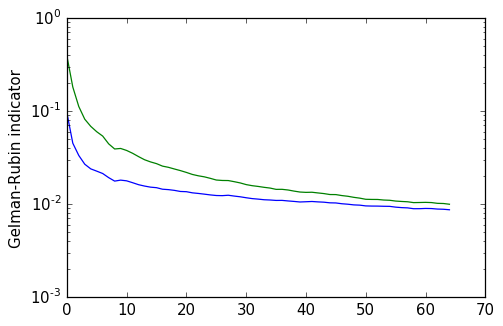

/Users/Jacob/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:1538: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


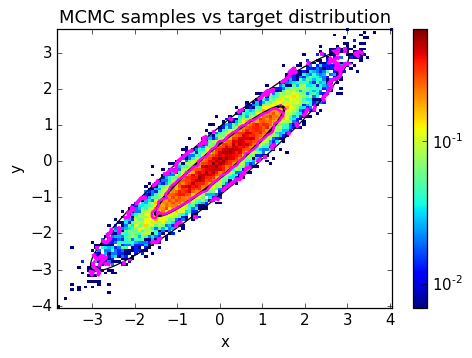

In [36]:
plt.rc('font', family='sans-serif', size=12)
plt.ylabel('Gelman-Rubin indicator')
plt.yscale('log')
plt.plot(zip(Rxval,Ryval))
plt.show()

plot_samples(xh,yh)

### Burn-in and thinning

It is always good to start the chain near the peak of the posterior. However, often information about the posterior is limited, at least for some of the parameters of the problem. The initial guess can thus be quite a bit off in the low-probability region. If steps are chosen reasonably, the chain will recover and, in fact, the initial samples in the low probability region are formally correct samples of the target pdf. 
Nevertheless,  these low probability values are often extremely improbable for the finite length of the sample chain that one generates in practice.  For example, if the 1D Gaussian pdf of zero mean and unit variance, $N(0,1)$, is sampled with the chain that was initialized at $x_0=10$ -- i.e., $10\sigma$ away from the peak, the <a href="http://www.aleph.se/andart/archives/2009/09/ten_sigma_numerics_and_finance.html">probability</a> of such sample is $\approx 1.5\times 10^{-23}$. Thus, we would need to have a chain of length $N\sim 10^{23}$ to make such sample normal. For samples of smaller $N$ this starting value can bias estimates of the mean, rms dispersion, etc. For example, with such initialization it takes the Metropolis algorithm $\sim 50-100$ steps to recover to the probably range of values. Thus, the first $\sim 50-100$ samples will need to be discarded for any realistic chain length to avoid any biases. 

The initial range of the improbable samples is called the burn-in period of the chain. Determining this period is handled in conjunction with deciding on chain convergence. Simple checks by how much one's estimates of the statistics of interest change after discarding a certain number of the initial samples may be enough in many instances, but a better criterion is to use auto-correlation time to determine the length of burn-in.  <a href="http://www.stat.unc.edu/faculty/cji/Sokal.pdf">Sokal (1996)</a> recommends to discard the first $N_b=20\tau_{\rm exp}$ samples, where $\tau_{\rm exp}$ is the auto-correlation time described above. This is implemented in the code above, although it may be overly conservative.

As noted above, MCMC chains produce $\sim N/\tau$ effectively independent samples. The chains thus are often <i>"thinned"</i> by selecting only each $(1\tau)^{th}$ sample and discarding the rest that don't contribute anything to the accuracy of the estimates from the posterior.  

The above criteria for burn-in and thinning are implemented in the above code. The walkers in the test above were initialized at $x=10$, $y=0$ - well away from the peak of the pdf. You can see that the burn-in criterion got rid of the improbable initial samples quite well. You can see them if you set ${\tt nburn}=0$. Overall, the sampling worked correctly as can be seen by good agreement between the 68% contour from the samples (magenta line) and expected for this pdf (thin black solid line under magenta). 

You can also see that the sampler generated $N_s\sim 6\times 10^5$ samples, but what's actually plotted is a rather noisy pdf sampling because the plotted chains were thinned and only $N\sim 10^4$ independent samples are plotted ($\tau\approx 50$). You can see that $R_{\rm GR}=1.01$ convergence criterion resulted in the number of independent samples sufficient to make estimates from the posterior with $\approx 1\%$ accuracy.

<b>Exercise 1:</b> run this example of 2D Gaussians with <b>emcee</b>. Convert modelpdf to lnPosterior. Determine how many steps to burn and how long to run the chain.  You will need some lines as below:

In [38]:


# 2D Gaussian function with correlation between variables
def modelpdf(x): #deals with the distributions of parameters, not the original data
    sig1 = 1.; sig2 = 1.; r = 0.95;
    r2 = r*r
    x1 = x[:,0]
    x2 = x[:,1]
    return np.exp(-0.5*((x1/sig1)**2+(x2/sig2)**2-2*r*x1*x2/(sig1*sig2))/(1-r2))/(2*np.pi*sig1*sig2)/np.sqrt(1-r2)

def modelpdf2(x1,x2):
    sig1 = 1.; sig2 = 1.; r = 0.95;
    r2 = r*r
    return np.exp(-0.5*((x1/sig1)**2+(x2/sig2)**2-2*r*x1*x2/(sig1*sig2))/(1-r2))/(2*np.pi*sig1*sig2)/np.sqrt(1-r2)

def lnLikelihood(p):
    sig1 = 1.; sig2 = 1.; r = 0.95;
    r2 = r*r
    x1 = p[0]
    x2 = p[1]
    twologL = -(((x1/sig1)**2+(x2/sig2)**2-2*r*x1*x2/(sig1*sig2))/(1-r2)) - 2. * \
                np.log(2*np.pi*sig1*sig2 / np.sqrt(1-r2))
    return twologL

def lnPrior(p):
    if not (0 < p[0] < 2):
        return -np.inf
    if not (-2 < p[1] < 2):
        return -np.inf      
    return 0.0

def lnPosterior(p): #We got rid of p[2] = sigma - not looking at it, only looking at a and b
    return lnPrior(p) + lnLikelihood(p)

In [40]:
import emcee #Does the same as above, but is much more efficient

ndim = 3
nwalkers = 100
nsteps = 300000
#nburn = 20000
np.random.seed(0)

# Choose an initial set of positions for the walkers
p0 = [np.random.rand(ndim) for i in xrange(nwalkers)]

# Initialize the sampler with the chosen specs
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnPosterior)

# Run burn-in steps
pos, prob, state = sampler.run_mcmc(p0, nburn/nwalkers) #last entry is number of burn steps per walker

# Reset the chain to remove the burn-in samples
sampler.reset()

# Starting from the final position in the burn-in chain, sample nsteps
sampler.run_mcmc(pos, nsteps/nwalkers, rstate0=state)

# Print out the mean acceptance fraction among all walkers
print "Mean acceptance fraction = %.3f" % np.mean(sampler.acceptance_fraction)

# Estimate the integrated autocorrelation time for the time series in each parameter.
#print "Autocorrelation length =", sampler.get_autocorr_time()

print "b = {0:.3f} +- {1:.3f}  s = {2:.3f} +- {3:.3f}"\
  .format(np.mean(sampler.flatchain[:,0]), np.std(sampler.flatchain[:,0]), \
   np.mean(np.abs(sampler.flatchain[:,1])), np.std(np.abs(sampler.flatchain[:,1])))
#sampler.flatchain is a 2D array of all the 'walkers' for each parameter - all the walkers
#collapsed into one

p1 = zip(*sampler.flatchain)[0]
p2 = zip(*sampler.flatchain)[1]

#nthin = int(max(sampler.get_autocorr_time()))
nthin = 50
nburn = int(20*nwalkers*nthin)
p1[nburn::nthin] #This is the thinned chain, for which we would calculate the mean and standard deviation

Mean acceptance fraction = 0.621
b = 0.594 +- 0.470  s = 0.604 +- 0.463


### Monte Carlo Integration

Pick $N$ random points $x_i$, uniformly distributed in a multidimensional volume $V$. The basic theorem of Monte Carlo integration estimates the integral of a function $f$ over the multidimensional volume as

$$ \int f(\mathbf{x}) dV \approx V \langle f\rangle \pm V \sqrt{\langle f^2\rangle - \langle f\rangle^2 \over N}, $$

where

$$ \langle f\rangle \equiv {1\over N} \sum\limits_{i=0}^{N-1} f(x_i). $$

It is implemented in a simple routine below.

In [ ]:
def simple_mcintegration(integrand, xmin, xmax, ndim, n):
    f, f2 = 0., 0.
    x = np.zeros(ndim)
    # integration volume
    volume = 1.
    for j in range(ndim):
        volume *= (xmax[j]-xmin[j])
    # calculate mean f and f^2
    for i in range(n):
        for j in range(ndim):
            x[j] = np.random.uniform(xmin[j], xmax[j])
        s = integrand(x)
        f += s
        f2 += s**2
    f = f/n
    f2 = f2/n
    # calculate the value of integral and estimated error
    result = volume*f
    error = volume*np.sqrt((f2-f**2)/n)
    return result, error

Let's try it on a very simple example - integration of the volume of a 3D sphere.

In [ ]:
def integrand(x):
    r = x[0]**2 + x[1]**2 + x[2]**2
    if r <= 1.:
        return 3./4./np.pi
    else:
        return 0.

ndim = 3
xmin = -1.*np.ones(ndim)
xmax = 1.*np.ones(ndim)
expected = 1.

for n in [1000, 10000, 100000, 1000000]:
    result, error = simple_mcintegration(integrand, xmin, xmax, ndim, n)
    
    print "n = %7d  Int = %.4f  estimated error = %.4f  actual error = %.4f"\
        % (n, result, error, abs(result-expected))

Now we take a more difficult case - integration over a thin shell.

In [ ]:
def integrand(x):
    r2 = x[0]**2 + x[1]**2 + x[2]**2
    d = 0.999
    d2 = d**2
    if d2 <= r2 and r2 <= 1.:
        return 3./4./np.pi/(1-d**3)
    else:
        return 0.

for n in [1000, 10000, 100000, 1000000]:
    result, error = simple_mcintegration(integrand, xmin, xmax, ndim, n)
    
    print "n = %7d  Int = %.4f  estimated error = %.4f  actual error = %.4f"\
        % (n, result, error, abs(result-expected))

Integration over a spherical volume can be done more efficiently in spherical coordinates:

$$ \int dV = \int\limits_{0}^{r} dr \int\limits_{0}^{\pi} d\theta \int\limits_{0}^{2\pi} d\phi $$

<b>Exercise 2:</b> change integration variables to spherical coordinates and compare the integration accuracy with the previous case of Cartesian coordinates.

Read on more efficient sampling techniques in [$\S$7.9](https://umich.instructure.com/files/715726/download) of [Numerical Recipes](http://numerical.recipes/).